# Task 2: Text Chunking, Embedding, and Vector Store Indexing


****

In [24]:
import pandas as pd
from pathlib import Path
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.vectorstores import FAISS  
from langchain.docstore.document import Document
from langchain_community.embeddings import SentenceTransformerEmbeddings
import pickle
import uuid
from langchain_community.embeddings import SentenceTransformerEmbeddings # Import the correct class
from langchain.embeddings import HuggingFaceEmbeddings 
import sys
import os 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))


## uploading of  files from prevous task

In [2]:
df=pd.read_csv('F:/Intelligent_Complaint_Analysis/data/filtered2_data.csv')
df.head()


,complaint_id,product,narrative,narrative_length,cleaned_narrative
0,14069121,Credit card,A XXXX XXXX card was opened under my name by a...,91,a card was opened under my name by a fraudster...
1,14047085,Credit card,"Dear CFPB, I have a secured credit card with c...",156,dear cfpb i have a secured credit card with ci...
2,14040217,Credit card,I have a Citi rewards cards. The credit balanc...,233,i have a citi rewards cards the credit balance...
3,13968411,Credit card,b'I am writing to dispute the following charge...,454,b i am writing to dispute the following charge...
4,13965746,Credit card,"Although the account had been deemed closed, I...",170,although the account had been deemed closed i ...


## Narrative Length statistics

In [3]:
# Check narrative lengths
df['narrative_length'] = df['cleaned_narrative'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
print("\nNarrative Length Statistics:")
print(df['narrative_length'].describe())


Narrative Length Statistics:
count    82164.000000
mean      1018.519132
std       1141.569812
min          0.000000
25%        318.000000
50%        710.000000
75%       1317.000000
max      30752.000000
Name: narrative_length, dtype: float64


**Initialize text splitter**

In [4]:
# Initialize text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,  # Reduced to handle shorter narratives
    chunk_overlap=50,
    length_function=len,
    separators=["\n\n", "\n", ".", " ", ""]
)

# **Chunking**
- preparing of document for chunking
- split narrative into Data
- Create Document objects with metadata

In [ ]:
# Prepare documents in batches
# 3. Call the function
from src.chunk_vector_store import chunk_cleaned_complaints_to_documents
documents = chunk_cleaned_complaints_to_documents(df, text_splitter)


Skipping empty narrative for Complaint ID c998d113-eed2-424c-8a04-7fb7559fa8d9
Processed batch 1: 2840 chunks so far
Processed batch 2: 5943 chunks so far
Processed batch 3: 8847 chunks so far
Processed batch 4: 11626 chunks so far
Processed batch 5: 14522 chunks so far
Processed batch 6: 17266 chunks so far
Processed batch 7: 20058 chunks so far
Processed batch 8: 22585 chunks so far
Processed batch 9: 25192 chunks so far
Processed batch 10: 27955 chunks so far
Processed batch 11: 30898 chunks so far
Processed batch 12: 33420 chunks so far
Processed batch 13: 36233 chunks so far
Processed batch 14: 38999 chunks so far
Processed batch 15: 41775 chunks so far
Processed batch 16: 44677 chunks so far
Processed batch 17: 47427 chunks so far
Processed batch 18: 50123 chunks so far
Processed batch 19: 52925 chunks so far
Processed batch 20: 55737 chunks so far
Processed batch 21: 58532 chunks so far
Processed batch 22: 61161 chunks so far
Processed batch 23: 63622 chunks so far
Processed bat

In [6]:
len(documents)

220221

## Desplaying of sample chunked documents

In [7]:
# to display chunked text
documents[:5]

[Document(metadata={'complaint_id': '4650b4d6-165f-4636-9079-ca642c64e0c3', 'product': 'Credit card', 'chunk_index': 0}, page_content='a card was opened under my name by a fraudster i received a notice from that an account was just opened under my name i reached out to to state that this activity was unauthorized and not me confirmed this was fraudulent and immediately closed the card however they have failed to remove this from the three credit agencies and this fraud is now impacting my credit score based on a hard credit pull done by that was done by a fraudster'),
 Document(metadata={'complaint_id': 'e4fe7411-02fc-4c45-92fd-8014d7504737', 'product': 'Credit card', 'chunk_index': 0}, page_content='dear cfpb i have a secured credit card with citibank which is changed to unsecured card and i have been calling n waitting for the check release the secured amount for rhat credit card they told me to wait then today they told me someone cashed my check but their system doesnt have info as

In [12]:
import pandas as pd

# Convert to DataFrame
DF = pd.DataFrame([{
    'text': doc.page_content,
    **doc.metadata  # expand metadata keys into columns
} for doc in documents])
DF.head()

,text,complaint_id,product,chunk_index
0,a card was opened under my name by a fraudster...,4650b4d6-165f-4636-9079-ca642c64e0c3,Credit card,0
1,dear cfpb i have a secured credit card with ci...,e4fe7411-02fc-4c45-92fd-8014d7504737,Credit card,0
2,wait for some form that might be sent to me vi...,e4fe7411-02fc-4c45-92fd-8014d7504737,Credit card,1
3,i have a citi rewards cards the credit balance...,9b686ddb-9281-40fc-a94f-28dfdf7c183b,Credit card,0
4,citi abruptly slashes the balance of my card f...,9b686ddb-9281-40fc-a94f-28dfdf7c183b,Credit card,1


# Generate embeddings and create vector **store**

In [ ]:
%pip install langchain-huggingface

In [8]:
# model loading
print("Loading embedding model...")
# Initialize SentenceTransformerEmbeddings with the model name
embedding_model = SentenceTransformerEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

Loading embedding model...


C:\Users\user\AppData\Local\Temp\ipykernel_23032\2483347866.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = SentenceTransformerEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


# **Generate embeddings and create vector store**

In [9]:


# Extract texts
texts = [doc.page_content for doc in documents]
metadatas = [doc.metadata for doc in documents]

# Embed in batches
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts, batch_size=64, show_progress_bar=True)


Batches: 100%|██████████| 3441/3441 [1:43:37<00:00,  1.81s/it]  


## sample of Embedded vector

In [10]:
# displaying of some vector
for i in range(3):
    print(f"\n📄 Text {i+1}:")
    print(texts[i])
    print("\n🔢 Embedding (first 10 dimensions):")
    print(embeddings[i][:20])


📄 Text 1:
a card was opened under my name by a fraudster i received a notice from that an account was just opened under my name i reached out to to state that this activity was unauthorized and not me confirmed this was fraudulent and immediately closed the card however they have failed to remove this from the three credit agencies and this fraud is now impacting my credit score based on a hard credit pull done by that was done by a fraudster

🔢 Embedding (first 10 dimensions):
[-0.03698349  0.02451562 -0.07761159  0.01777064  0.00104698 -0.01522342
  0.06904986 -0.05504384  0.04396294 -0.07325041  0.03577153  0.00561179
  0.06101048 -0.03145945 -0.02316688 -0.02266552  0.02141608  0.08439335
  0.00162158  0.02999533]

📄 Text 2:
dear cfpb i have a secured credit card with citibank which is changed to unsecured card and i have been calling n waitting for the check release the secured amount for rhat credit card they told me to wait then today they told me someone cashed my check but th

# saving as the vector and the Faiss_index

In [ ]:

# Build (text, embedding) tuples
text_embedding_pairs = list(zip(texts, embeddings))

# Create FAISS vector store
vector_store = FAISS.from_embeddings(
    text_embedding_pairs,
    embedding=model,           # model here should implement an .embed_query() method (SentenceTransformer is okay)
    metadatas=metadatas
)


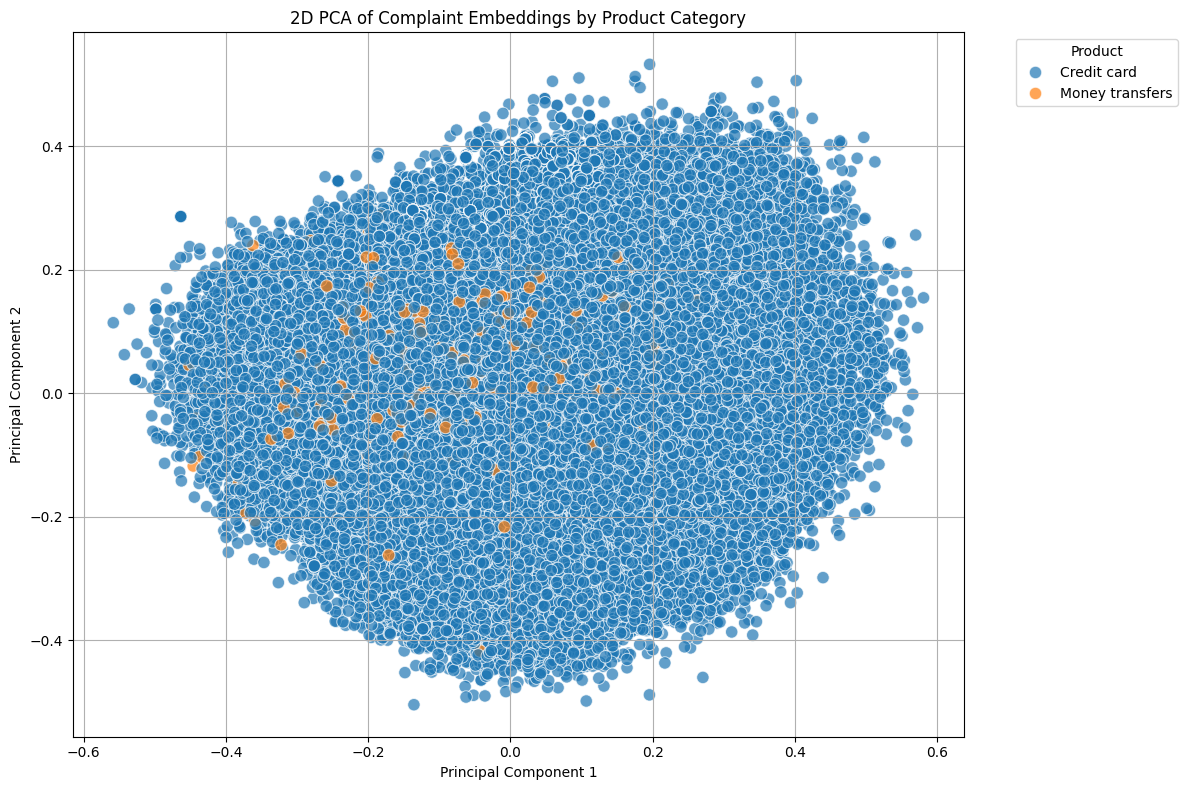

In [13]:
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)
DF['x'] = embeddings_2d[:, 0]
DF['y'] = embeddings_2d[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='x', y='y',
    hue='product',
    palette='tab10',
    data=DF,
    alpha=0.7,
    s=80
)

plt.title('2D PCA of Complaint Embeddings by Product Category')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# **Save vector store**

In [ ]:
vector_store.save_local("faiss_store/")


In [ ]:
# Set up paths
VECTOR_STORE_PATH = Path('vector_store')
VECTOR_STORE_FILE = VECTOR_STORE_PATH / 'faiss_index'
# Create vector store directory if it doesn't exist
VECTOR_STORE_PATH.mkdir(exist_ok=True)

print(f"Saving vector store to {VECTOR_STORE_FILE}...")
vector_store.save_local(VECTOR_STORE_FILE)